In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,1.65)
fontsize = 11

In [4]:
dataf = "../../data/clwbvsntstore.csv"

In [5]:
!sha256sum $dataf

74364bfc148a2475989287496b8c7001e82239849750847d209bc3aac42d00ef  ../../data/clwbvsntstore.csv


In [6]:
flights = sns.load_dataset("flights")
flights.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
year,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1951,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1957,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1959,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
passengers,112,118,132,129,121,135,148,148,136,119,104,118,115,126,141,135,125,149,170,170,158,133,114,140,145,150,178,163,172,178,199,199,184,162,146,166,171,180,193,181,183,218,230,242,209,191,172,194,196,196,236,235,229,243,264,272,237,211,180,201,204,188,235,227,234,264,302,293,259,229,203,229,242,233,267,269,270,315,364,347,312,274,237,278,284,277,317,313,318,374,413,405,355,306,271,306,315,301,356,348,355,422,465,467,404,347,305,336,340,318,362,348,363,435,491,505,404,359,310,337,360,342,406,396,420,472,548,559,463,407,362,405,417,391,419,461,472,535,622,606,508,461,390,432


In [7]:
df = pd.read_csv(dataf, index_col=None, names=['Write size', 'Drain interval', 'CLWB+SFENCE', 'NT-Store'])

In [8]:
df_norm = df.copy(deep=True)
df_norm['Speedup'] = df['CLWB+SFENCE'] / df['NT-Store']
del df_norm['CLWB+SFENCE']
del df_norm['NT-Store']

df_norm.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
Write size,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000,64.000000,64.000000,128.000000,128.000000,128.000000,128.00000,128.000000,128.000000,128.000000,128.000000,256.00000,256.00000,256.000000,256.000000,256.000000,256.000000,256.00000,256.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.00000,8192.000000,8192.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,16384.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.00000,32768.000000,32768.00000,32768.000000
Drain interval,1.000000,2.000000,4.000000,8.000000,16.000000,32.00000,64.000000,128.000000,1.000000,2.000000,4.000000,8.00000,16.000000,32.000000,64.000000,128.000000,1.00000,2.00000,4.000000,8.000000,16.000000,32.000000,64.00000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.00000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,1.000000,2.000000,4.000000,8.000000,16.00000,32.000000,64.00000,128.000000
Speedup,0.341916,0.489848,0.783401,1.181941,1.519999,1.91046,2.095172,2.214988,0.362957,0.602617,0.979546,1.10097,1.348562,1.522241,1.620173,1.630728,0.43527,0.76827,0.905169,1.215149,1.303225,1.385659,1.40678,1.420223,0.609708,0.761781,0.925841,0.983635,1.005376,1.031044,1.045261,1.056473,0.663265,0.818813,0.875191,0.954806,0.951289,0.962457,0.972874,0.971243,0.831484,0.960943,0.994767,1.024418,1.040132,1.050435,1.071163,1.055196,0.742883,0.807496,0.838646,0.845868,0.863314,0.875839,0.864201,0.866169,0.856073,0.876786,0.899404,0.925858,0.897222,0.89543,0.898503,0.899764,0.829917,0.841946,0.846675,0.848824,0.851975,0.863965,0.859684,0.851945,0.816467,0.821797,0.827928,0.826068,0.82688,0.824637,0.82593,0.829524


In [24]:
Fig.config(13, (8, 4))

Plot saved as `plots/pathfinding/clwbvsntstore.png`

Plot saved as `plots/pathfinding/clwbvsntstore.png`

Using pdfcrop on `plots/pathfinding/clwbvsntstore.png` with command `pdfcrop plots/pathfinding/clwbvsntstore.pdf plots/pathfinding/clwbvsntstore.pdf`

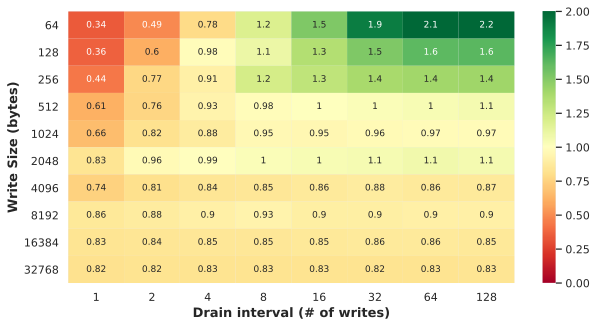

In [96]:
# define the colormap
cmap = plt.get_cmap('RdYlGn')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

df_pivot = df_norm.pivot("Write size", "Drain interval", "Speedup")
sns.set(font_scale = 1.2)
sns.set(rc={'figure.figsize':(10,5)})
g = sns.heatmap(df_pivot, annot=True, annot_kws={"size": 9}, cmap=cmap, vmin=0, vmax=2)
ax = g.axes
# g.set_yticklabels(g.get_yticks(), size = fontsize + 2)
# g.set_xticklabels(g.get_xticks(), size = fontsize + 2)
f = Fig(ax)
f.fmt_label('Drain interval (# of writes)', 'Write Size (bytes)')
f.save('clwbvsntstore')